In [1]:
import numpy as np
import scipy.io as scio
import pandas as pd

import VFC_dyad
import Idiff

import classification_accuracy

### 输入输出和参数设置

输入数据

In [2]:
# 输入数据路径
GROUP1_DATA2021_FOLDER = 'data2021/Class1-Parent'#亲子组
GROUP2_DATA2021_FOLDER = 'data2021/Class2-Stranger'#陌生人组
GROUP1_DATA2023_FOLDER = 'data2023/Class1-Parent'#亲子组
GROUP2_DATA2023_FOLDER = 'data2023/Class2-Stranger'#陌生人组
GROUP1_DATAALL_FOLDER = 'data_all/Class1-Parent'#亲子组
GROUP2_DATAALL_FOLDER = 'data_all/Class2-Stranger'#陌生人组

# 输入数据结构：
# 每个数据文件包含6种拼图场景，其中前面的1/2表示儿童拼或者成人拼，
# 后面的1/2/3表示单独/陪伴/合作,只关注3（合作）
sit_c1 = 'ca11' #儿童拼-单独
sit_a1 = 'ca21' #成人拼-单独
sit_c2 = 'ca12' #儿童拼-陪伴
sit_a2 = 'ca22' #成人拼-陪伴
sit_c3 = 'ca13' #儿童拼-合作
sit_a3 = 'ca23' #成人拼-合作
# 每种情况包含4个cell文件，分别对应4个频段：1-3，3-6，6-9，9-12
delta,theta,alpha,belta=0,1,2,3
freq_all=['delta','theta','alpha','belta']
# 每个cell文件的格式为通道数*时间点数*被试数
# 通道数: 其中1-28为儿童，29-56为成人，通过subc选择类型
# 28个通道及其对应的索引为：
channame_full = ['Fp1','Fp2','Fz','F3','F4','F7','F8','FC1','FC2','FC5','FC6','Cz','C3','C4','T7','T8','CP1','CP2','CP5','CP6','Pz','P3','P4','P7','P8','Oz','O1','O2']
id_chan_all = list(range(0,28))
# 26个通道及其对应的索引为：
channame_test = ['Fp1','Fp2','Fz','F3','F4','F7','F8','FC1','FC2','FC5','FC6','Cz','C3','C4','CP1','CP2','CP5','CP6','Pz','P3','P4','P7','P8','Oz','O1','O2']
id_chan_test = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

参数设置

In [3]:
# 参数设置
chan_num = 28 #通道数
edge_num = int(chan_num*(chan_num-1)/2) #边数
Nuptran_indices = VFC_dyad.uptran_mask(chan_num) #矩阵上三角列向量的位置
Euptran_indices = VFC_dyad.uptran_mask(edge_num) #矩阵上三角列向量的位置
Vtype='uptran'

# itype指边连接强度的计算方式，'p','c','d'分别代表：PLV复指数、corr相关、delta做差
itype_all=['e','c','d']
itype=itype_all[0]
# corr_type指边与边之间共波动特性的计算方式，'cos','pearson','delta'分别代表：
# 余弦相似度，皮尔逊相关系数，直接做差
corr_type_all=['cos','pearson','delta']
corr_type=corr_type_all[0]

tp=2000

sit=sit_c3 #拼图场景
freq=theta #频段
subc='child'  #对象类型 

dim_idx = [chan_num//2, chan_num, edge_num//2, edge_num]
# 所有亲子二人组dyad的文件路径
dyad_all = Idiff.file_path_infd(GROUP1_DATAALL_FOLDER)

## 1、个体识别性-总体Idiff

#### 1-1 nFC方法的结果，不降维
作用：验证nFC方法的降维结果

In [4]:
i=0
VnFC_subj=[]
trn_subj=[] #每种模态trail的数目

for dyad in dyad_all:
    # 导入mat数据
    data_mat = scio.loadmat(dyad)
    # data_mat的格式为情况*1*频段
    # 选择目标模态对应的数据，ts的格式为被试数*时间点数*通道数
    ts = data_mat[sit][0][freq].T
    # 时间点选择
    ts = ts[:,0:tp,:]
    # 群体subc选择
    if subc=='child': # 如果subject的类型为 child
        ts_subc = ts[:,:,0:28]
    elif subc=='adult': # 如果subject的类型为 adult
        ts_subc = ts[:,:,28:56]
    # 计算eFC的向量形式
    if Vtype=='all': #eFC列向量VeFC
        VnFC_file = VFC_dyad.VnFC_trail_all(ts_subc)
    elif Vtype=='uptran': #eFC上三角列向量VeFC_uptran
        VnFC_file = VFC_dyad.VnFC_trail_upt(ts_subc,Nuptran_indices)
    # 拼接同一个mode对应的所有文件中的eFC上三角列向量
    # 结果的维度为列向量长度*总的被试数
    trn_mdi=VnFC_file.shape[1]
    if i==0:
        VnFC_subj=VnFC_file
        trn_subj=trn_mdi
        i=1
    else:
        VnFC_subj=np.c_[VnFC_subj,VnFC_file]
        trn_subj=np.c_[trn_subj,trn_mdi]


I_diff,I_self,I_other,I_self_mean,per_change,per_diff=Idiff.get_Idiff(VnFC_subj,trn_subj,'pearsonr')
print('%.2f'%I_diff,'%.2f'%I_self_mean,'%.2f'%I_other)
# 保留两位小数并记录数据
I_concat = [I_diff,I_self_mean,I_other,per_change,per_diff]
I_nFC = np.around(I_concat,2)

8.89 0.65 0.56


In [ ]:
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VnFC_subj,trn_subj,1)
print(acrcy)
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VnFC_subj,trn_subj,3)
print(acrcy)
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VnFC_subj,trn_subj,5)
print(acrcy)

0.4991624790619765


In [5]:
acrcy = classification_accuracy.binary_classification_accuracy(VnFC_subj,trn_subj)
print(acrcy)

0.5658201894485146 0.46318097523144774
0.998324958123953


In [ ]:
def check_middle_pr(trn_subj,pearsonr_value_list,new_sheet_name):
    true_labels = classification_accuracy.get_true_labels(trn_subj)

    df_pearsonr_value_list = pd.DataFrame(pearsonr_value_list)
# 添加列名和索引
    df_pearsonr_value_list.columns= true_labels#设置列名
    df_pearsonr_value_list

# 创建一个新的工作表，命名为：场景+对象类型+频段
    output_excel='output/Classify_pearsonr_value.xlsx'
    # df=pd.DataFrame() #构造原始数据文件
    # df.to_excel(output_excel)
    excel_writer = pd.ExcelWriter(output_excel, mode='a',engine='openpyxl',if_sheet_exists='replace')
# 保存至excel
    df_pearsonr_value_list.to_excel(excel_writer, sheet_name=new_sheet_name)
    excel_writer._save()

acrcy,_,pearsonr_value_list = classification_accuracy.topk_sim_accuracy_meanpearsonr_middle_results(VnFC_subj,trn_subj,1)
check_middle_pr(trn_subj,pearsonr_value_list,'nfc')

#### 1-2 nFC方法的结果，降维

In [17]:
import VnFC_mst

def Idiff_mst_mn(nFC_mean_sort,mst_num):
    edge_list1,edge_list2=[],[]

    for mn in range(mst_num):
        sort = nFC_mean_sort[:,chan_num+mn*2][0]
        idx_i = sort//chan_num
        idx_j = sort%chan_num
    # 边列表1，2
        edge_list1 = np.append(edge_list1,idx_i)
        edge_list2 = np.append(edge_list2,idx_j)

    edge_list = np.c_[edge_list1,edge_list2]
    VnFC_mst_alld = VnFC_mst.VnFC_mst_all(dyad_all,sit,freq,subc,tp,
                             edge_list)
    I_diff,I_self,I_other,I_self_mean,per_change,per_diff=Idiff.get_Idiff(VnFC_mst_alld,trn_subj,'pearsonr')
# print('%.2f'%I_diff,'%.2f'%I_self_mean,'%.2f'%I_other)
# 保留两位小数并记录数据
    I_concat = [I_diff,I_self_mean,I_other,per_change,per_diff]
    I_nFC_mst = np.around(I_concat,2)

    return VnFC_mst_alld,I_nFC_mst

dyad_all = Idiff.file_path_infd(GROUP1_DATAALL_FOLDER)
nFC_mean_all = VnFC_mst.nFC_all_mean(dyad_all,sit,freq,subc,tp)
# 取绝对值
nFC_mean_abs = np.abs(nFC_mean_all)
nFC_mean_1d = nFC_mean_abs.reshape([1,len(nFC_mean_abs)**2])
nFC_mean_1d_inv = -nFC_mean_1d
nFC_mean_sort = nFC_mean_1d_inv.argsort()

In [ ]:
k = 0
dim_idx = [chan_num//2, chan_num, edge_num//2, edge_num]

for mst_num in dim_idx:
    VnFC_subj_mst, I_nFC_mst = Idiff_mst_mn(nFC_mean_sort,mst_num)
    if k==0:
        I_nFC_mst_all = I_nFC_mst
        k=1
    else:
        I_nFC_mst_all = np.c_[I_nFC_mst_all,I_nFC_mst]
    acrcy = classification_accuracy.topk_sim_accuracy_meanpearsonr(VnFC_subj_mst,trn_subj,1)
    print(acrcy)

In [20]:
# 转换为DataFrame格式
I_nFC_mst_allt=I_nFC_mst_all.T
df_nFC1 = pd.DataFrame(I_nFC_mst_allt)
# 添加列名和索引
df_nFC1.columns=['I_diff','I_self','I_other','Change_rate','Diff_rate'] #设置列名
df_nFC1
# # 创建一个新的工作表，命名为：场景+对象类型+频段
# output_excel='output/Diff_mst_all.xlsx'
# new_sheet_name = 'nFC' 
# excel_writer = pd.ExcelWriter(output_excel, mode='a',engine='openpyxl')
# # 保存至excel
# df_nFC1.to_excel(excel_writer, sheet_name=new_sheet_name)
# excel_writer.save()

,I_diff,I_self,I_other,Change_rate,Diff_rate
0,17.89,0.42,0.24,74.89,54.49
1,19.92,0.44,0.24,82.10,58.21
2,13.53,0.54,0.41,33.06,28.37
3,8.89,0.65,0.56,15.78,14.63


### 1-3 eFC方法的结果，使用最小生成树MST降维

In [8]:
# dyad_all = Idiff.file_path_infd(GROUP1_DATAALL_FOLDER)
# eFC_mean_all = VeFC_mst.eFC_all_mean(dyad_all,sit,freq,subc,corr_type,tp)
# # 取绝对值
# eFC_mean_abs = np.abs(eFC_mean_all)
# # 取1-原值：原值越大则1-原值越小，用于之后的最小生成树MST
# eFC_abs_inv = 1-eFC_mean_abs
# edge_list1,edge_list2=[],[]
# for edge1 in range(1,edge_num):
#     for edge2 in range(edge1):
#         # 边列表1，2
#         edge_list1 = np.append(edge_list1,edge1)
#         edge_list2 = np.append(edge_list2,edge2)
# eFC_Graph = MST_Graph.Graph()

# for i in range(edge_list1.shape[0]):
#     e1,e2=edge_list1[i],edge_list2[i]
#     e1,e2=int(e1),int(e2)
#     eFC_Graph.add_edge(e1,e2,-eFC_mean_abs[e1,e2])
    
# edge_mst_list = eFC_Graph.prim()
# edge_mst_ary = np.array(edge_mst_list)[:]
# edge_mst_idx = edge_mst_ary[:,:2]

In [6]:
import VeFC_mst

def Idiff_mst_mn_efc(eFC_mean_sort,mst_num):
    edge_list1,edge_list2=[],[]

    for mn in range(mst_num):
        sort = eFC_mean_sort[:,edge_num+mn*2][0]
        idx_i = sort//edge_num
        idx_j = sort%edge_num
    # 边列表1，2
        edge_list1 = np.append(edge_list1,idx_i)
        edge_list2 = np.append(edge_list2,idx_j)

    edge_list = np.c_[edge_list1,edge_list2]
    VeFC_mst_alld = VeFC_mst.VeFC_mst_all(dyad_all,sit,freq,subc,corr_type,tp,
                             edge_list)
    I_diff,I_self,I_other,I_self_mean,per_change,per_diff=Idiff.get_Idiff(VeFC_mst_alld,trn_subj,'pearsonr')
# print('%.2f'%I_diff,'%.2f'%I_self_mean,'%.2f'%I_other)
# 保留两位小数并记录数据
    I_concat = [I_diff,I_self_mean,I_other,per_change,per_diff]
    I_eFC_mst = np.around(I_concat,2)

    return VeFC_mst_alld,I_eFC_mst

eFC_mean_all = VeFC_mst.eFC_all_mean(dyad_all,sit,freq,subc,corr_type,tp)
# 取绝对值
eFC_mean_abs = np.abs(eFC_mean_all)
eFC_mean_1d = eFC_mean_abs.reshape([1,len(eFC_mean_abs)**2])
eFC_mean_1d_inv = -eFC_mean_1d
eFC_mean_sort = eFC_mean_1d_inv.argsort()

In [ ]:
k = 0

dim_idx = [chan_num//2, chan_num, edge_num//2, edge_num]
dim_idx = [edge_num*chan_num, edge_num*(edge_num-1)//2]
dim_idx = [chan_num//2, chan_num, edge_num//2, edge_num, edge_num*chan_num, edge_num*(edge_num-1)//2]
dim_idx = [edge_num*(edge_num-1)//2, edge_num]

for mst_num in dim_idx:
    VeFC_subj_mst,I_eFC_mst = Idiff_mst_mn_efc(eFC_mean_sort,mst_num)
    if k==0:
        I_eFC_mst_all = I_eFC_mst
        k=1
    else:
        I_eFC_mst_all = np.c_[I_eFC_mst_all,I_eFC_mst]
    acrcy = classification_accuracy.binary_classification_accuracy(VeFC_subj_mst,trn_subj)
    print(acrcy)

In [8]:
acrcy = classification_accuracy.binary_classification_accuracy(VeFC_subj_mst,trn_subj)
print(acrcy)

0.19210675885953546 0.09411935153986624
0.9865996649916248


In [ ]:
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VeFC_subj_mst,trn_subj,1)
print(acrcy)
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VeFC_subj_mst,trn_subj,3)
print(acrcy)
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VeFC_subj_mst,trn_subj,5)
print(acrcy)
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VeFC_subj_mst,trn_subj,10)
print(acrcy)
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VeFC_subj_mst,trn_subj,20)
print(acrcy)
acrcy,_ = classification_accuracy.topk_sim_accuracy_meanpearsonr1(VeFC_subj_mst,trn_subj,30)
print(acrcy)

0.4137353433835846
0.6180904522613065
0.7236180904522613


In [25]:
# 转换为DataFrame格式
I_eFC_mst_allt=I_eFC_mst_all.T
df_eFC1 = pd.DataFrame(I_eFC_mst_allt)
# 添加列名和索引
df_eFC1.columns=['I_diff','I_self','I_other','Change_rate','Diff_rate'] #设置列名
df_eFC1.index = dim_idx
print(df_eFC1)

       I_diff  I_self  I_other  Change_rate  Diff_rate
14      16.59    0.43     0.27        61.69      47.15
28      17.14    0.38     0.21        83.48      58.90
189     19.89    0.32     0.13       158.93      88.56
378     19.37    0.32     0.13       153.24      86.76
10584   14.50    0.42     0.27        52.84      41.80
71253    9.21    0.60     0.51        18.16      16.65


In [26]:
# 创建一个新的工作表，命名为：场景+对象类型+频段
output_excel='output/Diff_mst_all.xlsx'
new_sheet_name = 'eFC' 
excel_writer = pd.ExcelWriter(output_excel, mode='a',engine='openpyxl',if_sheet_exists='replace')
# 保存至excel
df_eFC1.to_excel(excel_writer, sheet_name=new_sheet_name)
excel_writer.save()

FileNotFoundError: [Errno 2] No such file or directory: 'output/Diff_mst_all.xlsx'

## 2、个体识别性-统计检验

#### Bootstrapping
使用Bootstrapping方法进行重抽样：30% = 15组，1000次

In [ ]:
import Idiff_bootstrap

I_eFC_all,I_nFC_all = Idiff_bootstrap.Idiff_boot(res_time=1000,yita=0.3,VeFC_mode=VeFC_subj_mst,VnFC_mode=VnFC_subj_mst,
         trn_mode=trn_subj)

In [ ]:
# 转换为DataFrame格式
I_eFC_allt=I_eFC_all.T
df_eFC1 = pd.DataFrame(I_eFC_allt)
# 添加列名和索引
df_eFC1.columns=['I_diff','I_self','I_other','Change_rate','Diff_rate'] #设置列名

# 转换为DataFrame格式
I_nFC_allt=I_nFC_all.T
df_nFC1 = pd.DataFrame(I_nFC_allt)
# 添加列名和索引
df_nFC1.columns=['I_diff','I_self','I_other','Change_rate','Diff_rate'] #设置列名

In [ ]:
output_excel_stats = 'output/Diff_dyad_mst_boot_all.xlsx'
# df=pd.DataFrame() #构造原始数据文件
# df.to_excel(output_excel_stats)

# 创建一个新的工作表，命名为：场景+对象类型+频段
new_sheet_name = sit+'-'+subc+'-'+freq_all[freq] 
# # 比较各个分支的结果
# new_sheet_name = itype+'-'+corr_type
excel_writer = pd.ExcelWriter(output_excel_stats, mode='a',engine='openpyxl',if_sheet_exists='replace')
'''df = pd.DataFrame({new_sheet_name: []})
df.to_excel(excel_writer, sheet_name=new_sheet_name, index=False)
excel_writer.save()'''
# 亲子组1个组的拼接
df_all = pd.concat([df_eFC1,df_nFC1],axis=1)

# 保存至excel
df_all.to_excel(excel_writer, sheet_name=new_sheet_name)
excel_writer.save()

NameError: name 'sit' is not defined

## 3、聚类结果可视化

In [ ]:
classification_accuracy.KMeans_s_ch_score(VnFC_subj,trn_subj)
classification_accuracy.KMeans_s_ch_score(VeFC_subj_mst,trn_subj)

In [33]:
true_labels = classification_accuracy.get_true_labels(trn_subj)
true_labels[:129]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

(129, 378)


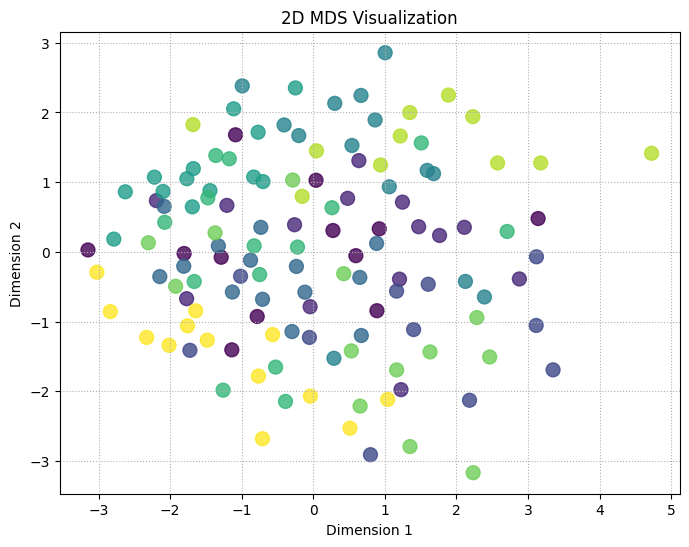

In [34]:
## MDS可视化
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# 构造原始高维数据
np.random.seed(0)
X_high_dim = VeFC_subj_mst.T[:129,:]
print(X_high_dim.shape)

# 计算距离矩阵
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(X_high_dim)

# 实例化MDS模型并进行降维
mds = MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(dist_matrix)

# 可视化降维结果
plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], s=100, c=true_labels[:129], alpha=0.8)
plt.title('2D MDS Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, linestyle='dotted')
plt.show()